In [1]:
import folium
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from geopy import distance
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('data/cleaned_train.csv', parse_dates=['OrderedDate', 'ClientCollected', 'GoodArrived'])
valid = pd.read_csv('data/validation.csv', parse_dates=['OrderedDate'])
test = pd.read_csv('data/test.csv', parse_dates=['OrderedDate'])

In [3]:
print(f'train shape: {train.shape}')
print(f'valid shape: {valid.shape}')
print(f'test shape: {test.shape}')

train shape: (587470, 29)
valid shape: (83385, 23)
test shape: (83117, 12)


In [4]:
def feats_generator(df):
    df['dow'] = df['OrderedDate'].dt.dayofweek
    df['hour'] = df['OrderedDate'].dt.hour
    df['date'] = df['OrderedDate'].dt.date
    df['day'] = df['OrderedDate'].dt.day
    
    df['city_id'] = city_encoder.transform(df['main_id_locality'])
    df['center_dist_from'] = df.apply(lambda r: get_distance(r['latitude'], r['longitude'], 
                                                             r['center_latitude'], r['center_longitude']), axis=1)
    df['center_dist_to'] = df.apply(lambda r: get_distance(r['del_latitude'], r['del_longitude'], 
                                                             r['center_latitude'], r['center_longitude']), axis=1)
    df['speed'] = df['EDA'] / df['ETA'] * 1000
    
    return df

def get_distance(latitude, longitude, del_latitude, del_longitude):
    """
    Get distance from start and destination coordinates.
    :param latitude: latitude coord
    :param longitude: longitude coord
    :param del_latitude: destination latitude coord
    :param del_longitude: destination longitude coord
    :return: distance in km
    """
    coord = (latitude, longitude)
    del_coord = (del_latitude, del_longitude)
    return distance.geodesic(coord, del_coord).km

def mape(y_true, y_pred):
    """
    MAPE metric eval.
    :param y_true:
    :param y_pred:
    :return: MAPE
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
city_encoder = LabelEncoder()
city_encoder.fit(train['main_id_locality'])

train = feats_generator(train)
valid = feats_generator(valid)
test = feats_generator(test)

In [6]:
train['target_ratio'] = train['RTA'] / train['ETA']
valid['target_ratio'] = valid['RTA'] / valid['ETA']

train['target_diff'] = train['RTA'] - train['ETA']
valid['target_diff'] = valid['RTA'] - valid['ETA']

# Чистим данные

### Удалим те поездки, где "Прибыл" была нажата слишком рано

In [7]:
train.columns

Index(['Id', 'main_id_locality', 'ETA', 'RTA', 'OrderedDate', 'latitude',
       'del_latitude', 'longitude', 'del_longitude', 'EDA', 'RDA',
       'ReadyForCollection', 'ClientCollected', 'GoodArrived',
       'ready_latitude', 'ready_longitude', 'onway_latitude',
       'onway_longitude', 'arrived_latitude', 'arrived_longitude',
       'center_latitude', 'center_longitude', 'route', 'track', 'dow', 'hour',
       'date', 'day', 'arrived_error', 'city_id', 'center_dist_from',
       'center_dist_to', 'speed', 'target_ratio', 'target_diff'],
      dtype='object')

In [99]:
feats = ['dow', 
         'hour', 
         'city_id',
         'ETA', 
         'center_dist_from', 
         'center_dist_to', 
         'EDA', 
         'speed']

target = 'target_ratio'

In [100]:
X = train[feats]
y = train[target]

In [101]:
model = CatBoostRegressor(loss_function='MAE')

In [102]:
model.fit(X=X, y=y, cat_features=[0, 1, 2])

0:	learn: 0.1634021	total: 159ms	remaining: 2m 38s
1:	learn: 0.1627853	total: 272ms	remaining: 2m 15s
2:	learn: 0.1621772	total: 378ms	remaining: 2m 5s
3:	learn: 0.1615975	total: 549ms	remaining: 2m 16s
4:	learn: 0.1610524	total: 731ms	remaining: 2m 25s
5:	learn: 0.1605568	total: 885ms	remaining: 2m 26s
6:	learn: 0.1600598	total: 994ms	remaining: 2m 21s
7:	learn: 0.1595905	total: 1.11s	remaining: 2m 17s
8:	learn: 0.1591551	total: 1.21s	remaining: 2m 13s
9:	learn: 0.1587283	total: 1.32s	remaining: 2m 10s
10:	learn: 0.1583357	total: 1.43s	remaining: 2m 8s
11:	learn: 0.1579426	total: 1.55s	remaining: 2m 7s
12:	learn: 0.1575891	total: 1.67s	remaining: 2m 7s
13:	learn: 0.1572378	total: 1.78s	remaining: 2m 5s
14:	learn: 0.1568982	total: 1.87s	remaining: 2m 3s
15:	learn: 0.1565783	total: 1.98s	remaining: 2m 1s
16:	learn: 0.1562745	total: 2.08s	remaining: 2m
17:	learn: 0.1559937	total: 2.19s	remaining: 1m 59s
18:	learn: 0.1557256	total: 2.3s	remaining: 1m 58s
19:	learn: 0.1554480	total: 2.4s	r

159:	learn: 0.1450517	total: 19.8s	remaining: 1m 43s
160:	learn: 0.1450236	total: 19.9s	remaining: 1m 43s
161:	learn: 0.1449963	total: 20.1s	remaining: 1m 43s
162:	learn: 0.1449778	total: 20.3s	remaining: 1m 44s
163:	learn: 0.1449648	total: 20.5s	remaining: 1m 44s
164:	learn: 0.1449462	total: 20.7s	remaining: 1m 44s
165:	learn: 0.1449202	total: 20.8s	remaining: 1m 44s
166:	learn: 0.1448954	total: 21s	remaining: 1m 44s
167:	learn: 0.1448758	total: 21.1s	remaining: 1m 44s
168:	learn: 0.1448532	total: 21.2s	remaining: 1m 44s
169:	learn: 0.1448386	total: 21.3s	remaining: 1m 44s
170:	learn: 0.1448199	total: 21.5s	remaining: 1m 44s
171:	learn: 0.1448034	total: 21.6s	remaining: 1m 43s
172:	learn: 0.1447862	total: 21.7s	remaining: 1m 43s
173:	learn: 0.1447661	total: 21.8s	remaining: 1m 43s
174:	learn: 0.1447425	total: 21.9s	remaining: 1m 43s
175:	learn: 0.1447257	total: 22.1s	remaining: 1m 43s
176:	learn: 0.1447066	total: 22.2s	remaining: 1m 43s
177:	learn: 0.1446858	total: 22.3s	remaining: 1m

315:	learn: 0.1431276	total: 39.5s	remaining: 1m 25s
316:	learn: 0.1431204	total: 39.6s	remaining: 1m 25s
317:	learn: 0.1431123	total: 39.8s	remaining: 1m 25s
318:	learn: 0.1431065	total: 39.9s	remaining: 1m 25s
319:	learn: 0.1431022	total: 40s	remaining: 1m 24s
320:	learn: 0.1430965	total: 40.1s	remaining: 1m 24s
321:	learn: 0.1430873	total: 40.3s	remaining: 1m 24s
322:	learn: 0.1430817	total: 40.4s	remaining: 1m 24s
323:	learn: 0.1430734	total: 40.5s	remaining: 1m 24s
324:	learn: 0.1430620	total: 40.6s	remaining: 1m 24s
325:	learn: 0.1430580	total: 40.8s	remaining: 1m 24s
326:	learn: 0.1430493	total: 40.9s	remaining: 1m 24s
327:	learn: 0.1430435	total: 41s	remaining: 1m 24s
328:	learn: 0.1430374	total: 41.2s	remaining: 1m 23s
329:	learn: 0.1430310	total: 41.3s	remaining: 1m 23s
330:	learn: 0.1430221	total: 41.4s	remaining: 1m 23s
331:	learn: 0.1430138	total: 41.5s	remaining: 1m 23s
332:	learn: 0.1430085	total: 41.6s	remaining: 1m 23s
333:	learn: 0.1430016	total: 41.8s	remaining: 1m 2

472:	learn: 0.1422325	total: 1m	remaining: 1m 7s
473:	learn: 0.1422270	total: 1m	remaining: 1m 7s
474:	learn: 0.1422203	total: 1m	remaining: 1m 6s
475:	learn: 0.1422169	total: 1m	remaining: 1m 6s
476:	learn: 0.1422122	total: 1m	remaining: 1m 6s
477:	learn: 0.1422078	total: 1m	remaining: 1m 6s
478:	learn: 0.1422029	total: 1m 1s	remaining: 1m 6s
479:	learn: 0.1421993	total: 1m 1s	remaining: 1m 6s
480:	learn: 0.1421957	total: 1m 1s	remaining: 1m 6s
481:	learn: 0.1421925	total: 1m 1s	remaining: 1m 6s
482:	learn: 0.1421857	total: 1m 1s	remaining: 1m 5s
483:	learn: 0.1421793	total: 1m 1s	remaining: 1m 5s
484:	learn: 0.1421773	total: 1m 1s	remaining: 1m 5s
485:	learn: 0.1421723	total: 1m 1s	remaining: 1m 5s
486:	learn: 0.1421688	total: 1m 2s	remaining: 1m 5s
487:	learn: 0.1421658	total: 1m 2s	remaining: 1m 5s
488:	learn: 0.1421639	total: 1m 2s	remaining: 1m 5s
489:	learn: 0.1421590	total: 1m 2s	remaining: 1m 5s
490:	learn: 0.1421552	total: 1m 2s	remaining: 1m 4s
491:	learn: 0.1421504	total: 1

630:	learn: 0.1416791	total: 1m 20s	remaining: 46.8s
631:	learn: 0.1416771	total: 1m 20s	remaining: 46.7s
632:	learn: 0.1416751	total: 1m 20s	remaining: 46.6s
633:	learn: 0.1416737	total: 1m 20s	remaining: 46.4s
634:	learn: 0.1416718	total: 1m 20s	remaining: 46.3s
635:	learn: 0.1416683	total: 1m 20s	remaining: 46.1s
636:	learn: 0.1416643	total: 1m 20s	remaining: 46s
637:	learn: 0.1416623	total: 1m 20s	remaining: 45.9s
638:	learn: 0.1416604	total: 1m 20s	remaining: 45.8s
639:	learn: 0.1416576	total: 1m 21s	remaining: 45.6s
640:	learn: 0.1416552	total: 1m 21s	remaining: 45.5s
641:	learn: 0.1416521	total: 1m 21s	remaining: 45.4s
642:	learn: 0.1416493	total: 1m 21s	remaining: 45.2s
643:	learn: 0.1416453	total: 1m 21s	remaining: 45.1s
644:	learn: 0.1416432	total: 1m 21s	remaining: 45s
645:	learn: 0.1416418	total: 1m 21s	remaining: 44.8s
646:	learn: 0.1416403	total: 1m 21s	remaining: 44.7s
647:	learn: 0.1416345	total: 1m 22s	remaining: 44.6s
648:	learn: 0.1416326	total: 1m 22s	remaining: 44.

786:	learn: 0.1412729	total: 1m 40s	remaining: 27.1s
787:	learn: 0.1412702	total: 1m 40s	remaining: 27s
788:	learn: 0.1412666	total: 1m 40s	remaining: 26.9s
789:	learn: 0.1412638	total: 1m 40s	remaining: 26.7s
790:	learn: 0.1412612	total: 1m 40s	remaining: 26.6s
791:	learn: 0.1412592	total: 1m 40s	remaining: 26.5s
792:	learn: 0.1412577	total: 1m 41s	remaining: 26.4s
793:	learn: 0.1412554	total: 1m 41s	remaining: 26.2s
794:	learn: 0.1412530	total: 1m 41s	remaining: 26.1s
795:	learn: 0.1412481	total: 1m 41s	remaining: 26s
796:	learn: 0.1412441	total: 1m 41s	remaining: 25.9s
797:	learn: 0.1412422	total: 1m 41s	remaining: 25.7s
798:	learn: 0.1412409	total: 1m 41s	remaining: 25.6s
799:	learn: 0.1412390	total: 1m 41s	remaining: 25.5s
800:	learn: 0.1412358	total: 1m 41s	remaining: 25.3s
801:	learn: 0.1412332	total: 1m 42s	remaining: 25.2s
802:	learn: 0.1412309	total: 1m 42s	remaining: 25.1s
803:	learn: 0.1412301	total: 1m 42s	remaining: 24.9s
804:	learn: 0.1412264	total: 1m 42s	remaining: 24.

943:	learn: 0.1409846	total: 2m 1s	remaining: 7.19s
944:	learn: 0.1409815	total: 2m 1s	remaining: 7.07s
945:	learn: 0.1409795	total: 2m 1s	remaining: 6.94s
946:	learn: 0.1409780	total: 2m 1s	remaining: 6.81s
947:	learn: 0.1409772	total: 2m 1s	remaining: 6.68s
948:	learn: 0.1409732	total: 2m 1s	remaining: 6.55s
949:	learn: 0.1409708	total: 2m 2s	remaining: 6.42s
950:	learn: 0.1409682	total: 2m 2s	remaining: 6.29s
951:	learn: 0.1409663	total: 2m 2s	remaining: 6.17s
952:	learn: 0.1409649	total: 2m 2s	remaining: 6.04s
953:	learn: 0.1409626	total: 2m 2s	remaining: 5.91s
954:	learn: 0.1409614	total: 2m 2s	remaining: 5.78s
955:	learn: 0.1409594	total: 2m 2s	remaining: 5.65s
956:	learn: 0.1409571	total: 2m 2s	remaining: 5.52s
957:	learn: 0.1409558	total: 2m 3s	remaining: 5.4s
958:	learn: 0.1409549	total: 2m 3s	remaining: 5.27s
959:	learn: 0.1409541	total: 2m 3s	remaining: 5.15s
960:	learn: 0.1409518	total: 2m 3s	remaining: 5.02s
961:	learn: 0.1409501	total: 2m 3s	remaining: 4.89s
962:	learn: 0

In [103]:
valid_X = valid[feats]
valid_y = valid['RTA']

In [104]:
valid_pred = model.predict(valid_X)

In [105]:
valid_pred = valid_pred * valid['ETA']

In [106]:
# loss MAE, target_ratio
mape(valid_y, valid_pred)

15.838111425606677

In [61]:
# loss MAPE, target_ETA
mape(valid_y, valid_pred)

23.563323998781538

In [69]:
# loss MAPE, target_ratio
mape(valid_y, valid_pred)

15.86644195494928

In [54]:
# loss RMSE, target_ratio
mape(valid_y, valid_pred)

16.927855523802453

In [32]:
# loss MAPE, target_diff
mape(valid_y, valid_pred)

22.929719343424974

In [20]:
# loss RMSE, target_diff
mape(valid_y, valid_pred)

17.03656205846243

In [71]:
test_X = test[feats]

In [89]:
test_y = model.predict(test_X) * test['ETA']

In [90]:
test_y = pd.Series(test_y)

In [91]:
test_y.name = 'Prediction'

In [92]:
test_y

0         449.291926
1        1157.686064
2         462.448738
3        1048.570052
4         291.278332
            ...     
83112    1286.117781
83113     603.793938
83114     329.207059
83115     845.116376
83116     802.179852
Name: Prediction, Length: 83117, dtype: float64

In [95]:
test_y.to_frame().index.rename('id', inplace=True)

In [98]:
test_y.to_frame().to_csv('results/submit_catboost_mape_ratio.csv')

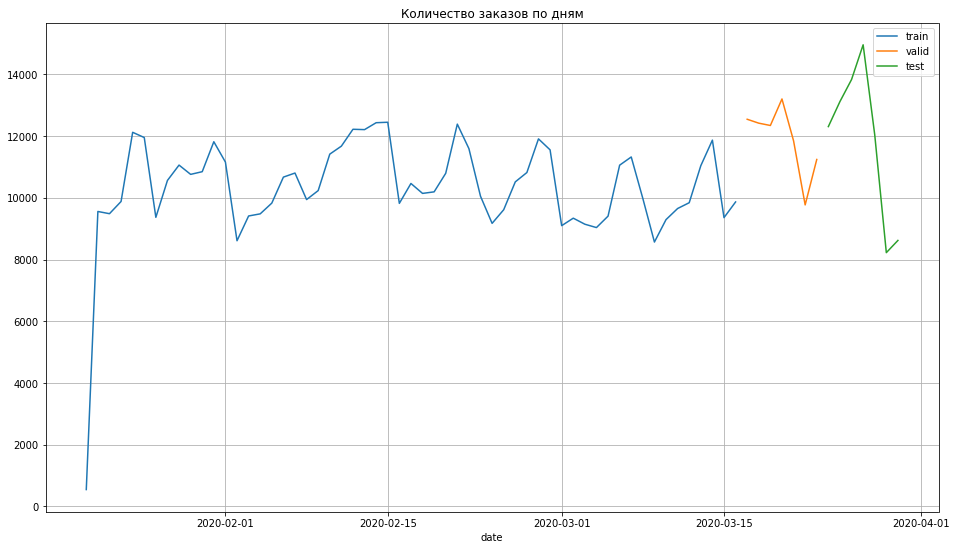

In [15]:
train.groupby('date').size().plot(figsize=(16,9), grid=True, label='train')
valid.groupby('date').size().plot(figsize=(16,9), grid=True, label='valid')
test.groupby('date').size().plot(figsize=(16,9), grid=True, label='test')

plt.title('Количество заказов по дням')
plt.legend()

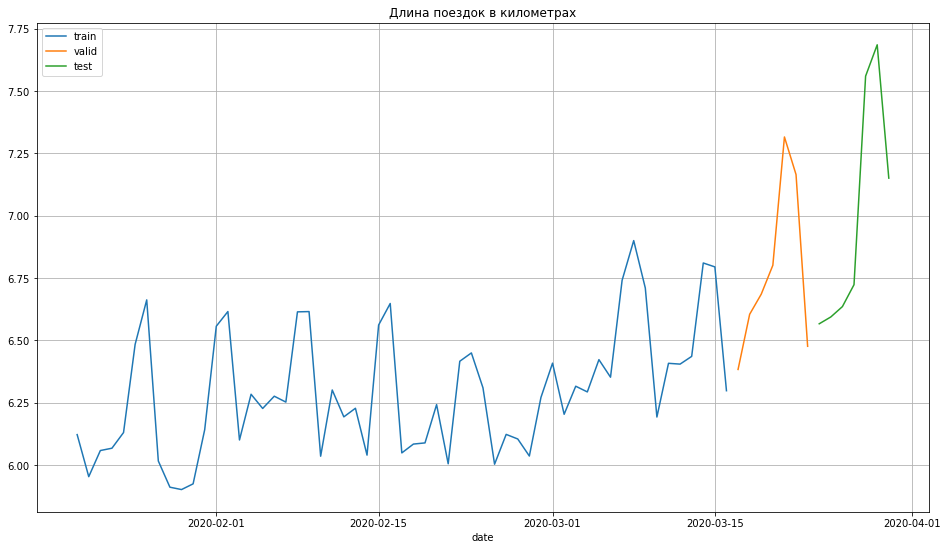

In [24]:
train.groupby('date')['EDA'].mean().plot(figsize=(16,9), grid=True, label='train')
valid.groupby('date')['EDA'].mean().plot(figsize=(16,9), grid=True, label='valid')
test.groupby('date')['EDA'].mean().plot(figsize=(16,9), grid=True, label='test')

plt.title('Длина поездок в километрах')
plt.legend()

plt.savefig('results/eda.png', bbox_inches='tight')